In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from tqdm.autonotebook import tqdm
from torchsummary import summary

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
!nvidia-smi

Sat May  2 18:25:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
! pip install -q kaggle
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:37<00:00, 54.2MB/s]
100% 2.29G/2.29G [00:37<00:00, 66.2MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
import torchvision.transforms as transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(10),
        transforms.ToTensor(),
        
    ]),
    'test': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.ToTensor(),
        
    ]),
}

In [0]:
data_path = "/content/chest_xray/"

In [0]:
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train', transform=data_transforms['train'])
train_dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=4)


test_dataset = torchvision.datasets.ImageFolder(data_path + 'test', transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=4,
                        shuffle=False, num_workers=4)

In [0]:
label_dict = dict()
for key, value in train_dataset.class_to_idx.items():
    label_dict[value] = key

In [0]:
data_iter = iter(train_dataloader)
images, labels = data_iter.next()

In [0]:
def imshow(img, one_channel = True):
    npimg = img.cpu().numpy()
    if one_channel:
        npimg = np.squeeze(npimg)
        plt.imshow(npimg, cmap = 'gray')
    else:
        plt.imshow(np.transpose(npimg, axes = (1, 2, 0)))

In [0]:
imgrid = torchvision.utils.make_grid(images)

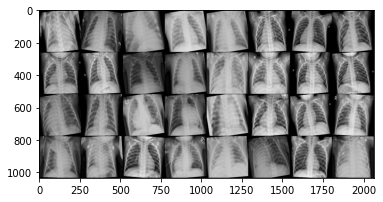

In [272]:
imshow(imgrid, one_channel= False)

In [0]:
model = torchvision.models.resnet34(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(
                      torch.nn.Linear(512, 2))


In [274]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [276]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [0]:
def images_to_probs(model, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model(images)
    output = torch.softmax(output, 1)

    probs, preds = torch.max(output, 1)

    
    
    return probs, preds

In [0]:
def plot_classes_preds(model, images, labels, label_dict):
    probs, preds = images_to_probs( model, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 4))
    for idx in range(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        if images.shape[1] == 3:
            imshow(images[idx],one_channel= False)
        else:
            imshow(images[idx])
        
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            label_dict[int(preds[idx].detach().cpu())],
            probs[idx]*100,
            label_dict[int(labels[idx].detach().cpu())]),
            color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

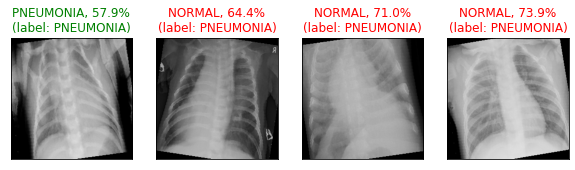

In [280]:
fig = plot_classes_preds(model, images.to(device), labels.to(device), label_dict)

In [48]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
!rm -rf runs

In [0]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/chest')

writer.add_image('some_chest', imgrid)
writer.add_graph(model, images.to(device))
writer.close()

In [283]:
%tensorboard --logdir=runs

<IPython.core.display.Javascript object>

In [0]:
def fit(model, dataloader, loss, optimizer, device, label_dict, writer =None, epochs= 5, print_every = 100):
    model.train()
    for epoch in tqdm(range(epochs)):
        running_cost = 0.0
        for i, data in enumerate(tqdm(dataloader, leave = False)):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            J = loss(outputs, labels)
            J.backward()
            optimizer.step()
            if (writer != None):
                running_cost += J.item()
                if i % print_every == (print_every-1):
                    writer.add_scalar('training_cost',
                                      running_cost / print_every,
                                      epoch * len(dataloader) + i)

                    writer.add_figure('predictions vs. actuals',
                                      plot_classes_preds(model, inputs, labels, label_dict),
                                      global_step=epoch * len(dataloader) + i)
                    running_cost = 0.0

In [0]:
def accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the images: %d %%' % (
          100 * correct / total))

In [287]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
fit(model, train_dataloader, loss, optimizer, device, label_dict,writer, epochs = 3, print_every = 10)

In [288]:
accuracy(model, train_dataloader, device)
accuracy(model, test_dataloader, device)

Accuracy of the network on the images: 95 %
Accuracy of the network on the images: 82 %


In [0]:
for param in model.parameters():
    param.requires_grad = True

In [290]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
fit(model, train_dataloader, loss, optimizer, device, label_dict,writer, epochs = 1, print_every = 10)

In [291]:
accuracy(model, train_dataloader, device)
accuracy(model, test_dataloader, device)

Accuracy of the network on the images: 98 %
Accuracy of the network on the images: 83 %
